In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.datasets import TranslationDataset, Multi30k, IWSLT
from torchtext.data import Field, BucketIterator, Iterator
import spacy
import numpy as np
import random
import math
import time
from collections import defaultdict
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import itertools

In [0]:
%%capture
!python3 -m spacy download en
!python3 -m spacy download de

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sos_token='<sos>'
eos_token='<eos>'
pad_token='<pad>'
unk_token='<unk>'

def tokenize_de(text):
    return [token.text for token in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in spacy_en.tokenizer(text)]

In [0]:
TRG = Field(init_token=sos_token, 
            eos_token=eos_token,
            lower=True, 
            tokenize=tokenize_en,
            pad_token=pad_token, 
            unk_token=unk_token)

SRC = Field(init_token=sos_token, 
            eos_token=eos_token,
            lower=True, 
            tokenize=tokenize_de,
            pad_token=pad_token, 
            unk_token=unk_token)

In [0]:
%%capture
train_data, _, _ = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        filter_pred=lambda x: len(x.__dict__['src']) <= 50)

test_10, valid_10, valid_12 = IWSLT.splits(exts = ('.de', '.en'), 
                                fields = (SRC, TRG),
                                train='IWSLT16.TED.tst2010',
                                test='IWSLT16.TED.dev2010',
                                validation='IWSLT16.TEDX.dev2012',
                                filter_pred=lambda x: len(x.__dict__['src']) <= 60)

test_11, test_12, test_13 = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        train='IWSLT16.TED.tst2011',
                        validation='IWSLT16.TED.tst2012',
                        test='IWSLT16.TED.tst2013',
                        filter_pred=lambda x: len(x.__dict__['src']) <= 60)

test_13x, test_14x, test_14 = IWSLT.splits(exts = ('.de', '.en'), 
                        fields = (SRC, TRG),
                        train='IWSLT16.TEDX.tst2013',
                        validation='IWSLT16.TEDX.tst2014',
                        test='IWSLT16.TED.tst2014',
                        filter_pred=lambda x: len(x.__dict__['src']) <= 60)

valid_data = [valid_10, valid_12]
test_data = [test_10, test_11, test_12, test_13, test_13x, test_14x, test_14]

In [0]:
SRC.build_vocab(train_data, max_size=10000)
TRG.build_vocab(train_data, max_size=10000)

In [0]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional = True)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return hidden[-1,:,:].unsqueeze(0)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim)
        self.fc_out = nn.Linear(emb_dim + (hid_dim * 2), output_dim)
        
    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        emb_con = torch.cat((embedded, context), dim = 2)
        output, hidden = self.rnn(emb_con, hidden)
        output = torch.cat((embedded.squeeze(0), hidden.squeeze(0), context.squeeze(0)), 
                           dim = 1)
        prediction = self.fc_out(output)
        return prediction, hidden

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs
        
    def translate(self, sentence, max_len=50, beam_width=3):
        self.eval()
        src = SRC.process([sentence]).to(device)
        context = self.encoder(src)
        hidden = context
        beams = [(0.0, [TRG.vocab.stoi[TRG.init_token]], hidden)]
        done = False
        log_smax = nn.LogSoftmax(dim=0).to(device)

        while not done:
            for i in range(len(beams)):
                p, sent, hidden = beams.pop(0)
                if len(sent) >= max_len or sent[-1] == TRG.vocab.stoi[TRG.eos_token]:
                    beams += [(p, sent, hidden)]
                    continue
                trg = torch.ones(1, dtype=torch.int64).to(device) * sent[-1]
                pred, hidden = self.decoder(trg, hidden, context)
                ll = log_smax(pred[0])
                top_ll, top_t = torch.topk(ll, k=beam_width)
                beams += [(p + ll, sent + [t], hidden) for ll, t in zip(top_ll, top_t)]
            beams = sorted(beams, reverse=True)[:beam_width]
            done = all([b[1][-1] == TRG.vocab.stoi[TRG.eos_token] or len(b[1]) >= max_len for b in beams])

        trgs = beams.pop(0)[1]
        return [TRG.vocab.itos[i] for i in trgs]

In [0]:
class EncoderAttn(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden[1]

class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear(2 * enc_hid_dim + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

class DecoderAttn(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

class Search(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

        
    def translate(self, sentence, max_len=50, beam_width=3):
        self.eval()
        src = SRC.process([sentence]).to(device)
        encoder_out, hidden = self.encoder(src)
        beams = [(0.0, [TRG.vocab.stoi[TRG.init_token]], hidden)]
        done = False
        log_smax = nn.LogSoftmax(dim=0).to(device)

        while not done:
            for i in range(len(beams)):
                p, sent, hidden = beams.pop(0)
                if len(sent) >= max_len or sent[-1] == TRG.vocab.stoi[TRG.eos_token]:
                    beams += [(p, sent, hidden)]
                    continue
                trg = torch.ones(1, dtype=torch.int64).to(device) * sent[-1]
                pred, hidden = self.decoder(trg, hidden, encoder_out)
                ll = log_smax(pred[0])
                top_ll, top_t = torch.topk(ll, k=beam_width)
                beams += [(p + ll, sent + [t], hidden) for ll, t in zip(top_ll, top_t)]
            beams = sorted(beams, reverse=True)[:beam_width]
            done = all([b[1][-1] == TRG.vocab.stoi[TRG.eos_token] or len(b[1]) >= max_len for b in beams])

        trgs = beams.pop(0)[1]
        return [TRG.vocab.itos[i] for i in trgs]

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 300
DEC_EMB_DIM = 300
HID_DIM = 600
MAX_LENGTH = 50

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
enc_dec = EncoderDecoder(enc, dec, device).to(device)

att = Attention(HID_DIM, HID_DIM)
enc = EncoderAttn(INPUT_DIM, ENC_EMB_DIM, HID_DIM, HID_DIM)
dec = DecoderAttn(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, HID_DIM, att)
search = Search(enc, dec, device).to(device)

In [0]:
def evaluate_bleu(model, datasets):
    overall_size = sum([len(d) for d in datasets])
    total = 0.0
    for i, example in enumerate(itertools.chain(*datasets)):
        pred = model.translate(example.src)[1:-2]
        total += sentence_bleu([example.trg], pred, smoothing_function=SmoothingFunction().method1)
        if i % 200 == 199: print('.', end='')
    print('')
    return total / overall_size
    
def bleu_summary(model, datasets):
    overall_examples = sum([len(d) for d in datasets])
    lengths = np.zeros(overall_examples, dtype=np.int32)
    scores = np.zeros(overall_examples)

    for i, example in enumerate(itertools.chain(*datasets)):
        pred = model.translate(example.src)
        scores[i] = sentence_bleu([example.trg], pred, smoothing_function=SmoothingFunction().method1)
        lengths[i] = len(example.src)
        if i % 900 == 899: print('.', end='')
        
    print('')
    means, up, lo = {}, {}, {}
    uniq_lengths, counts = np.unique(lengths, return_counts=True)
    for l, c in zip(uniq_lengths, counts):
        s = scores[lengths == l]
        means[l] = s.mean()
        up[l] = means[l] + (np.sqrt(s.var() / c) * 1.65)
        lo[l] = means[l] - (np.sqrt(s.var() / c) * 1.65)

    uniq_lengths = [l for l in sorted(uniq_lengths)]
    return uniq_lengths, [means[l] for l in uniq_lengths], [up[l] for l in uniq_lengths], [lo[l] for l in uniq_lengths]

In [0]:
ctrl_valid_bleu = []
attn_valid_bleu = []

for i in range(11):
    print(f'Epoch {i}')
    enc_dec.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-{i}.pt'))
    search.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-attention/epoch-{i}.pt'))
    ctrl_valid_bleu.append(evaluate_bleu(enc_dec, valid_data))
    attn_valid_bleu.append(evaluate_bleu(search, valid_data))

np.argmax(ctrl_valid_bleu), np.argmax(attn_valid_bleu)

Epoch 0
..........
..........
Epoch 1
..........
..........
Epoch 2
..........
..........
Epoch 3
..........
..........
Epoch 4
..........
..........
Epoch 5
..........
..........
Epoch 6
..........
..........
Epoch 7
..........
..........
Epoch 8
..........
..........
Epoch 9
..........
..........
Epoch 10
..........
..........


(5, 5)

In [0]:
np.argmax(ctrl_valid_bleu), np.argmax(attn_valid_bleu)

(5, 5)

In [0]:
ctrl_valid_bleu = [0.00027585067543308897,
 0.06403091167898425,
 0.08367007531601396,
 0.09073138328255839,
 0.09854313939914648,
 0.0996926188394328,
 0.09478283601730382,
 0.09605205359629668,
 0.09895425369812172,
 0.09859945881889891,
 0.09865091877403412]

In [0]:
attn_valid_bleu = [0.00020348121971613134,
 0.11477070277982021,
 0.14709354763141827,
 0.14709118007312405,
 0.15037970841710047,
 0.15309581992306245,
 0.15183340045879234,
 0.1498278608716279,
 0.1391850587348392,
 0.14791511145398423,
 0.13950492178298043]

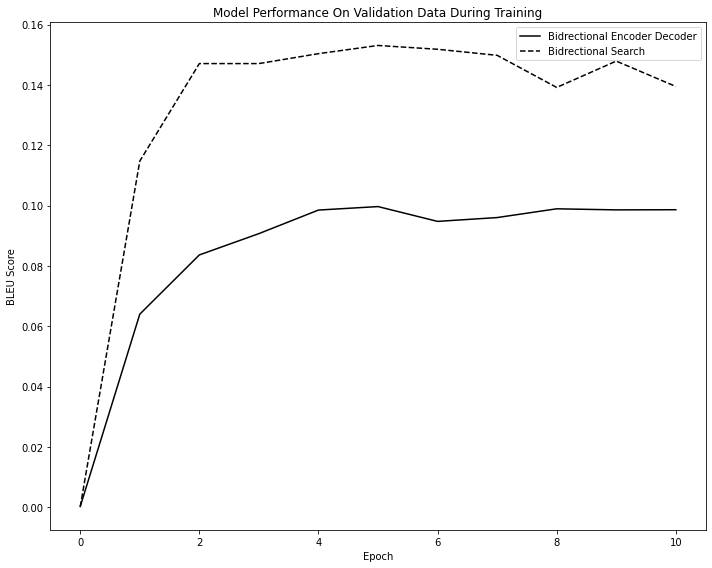

In [0]:
fig, ax = plt.subplots(figsize=(10,8))

ax.set_ylabel('BLEU Score')
ax.set_xlabel('Epoch')
ax.plot(list(range(11)), ctrl_valid_bleu, linestyle='-', color='black', label="Bidrectional Encoder Decoder")
ax.plot(list(range(11)), attn_valid_bleu, linestyle='--', color='black', label="Bidrectional Search")
ax.set_title('Model Performance On Validation Data During Training')

ax.legend()

fig.tight_layout()
plt.show()

In [0]:
enc_dec.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-control/epoch-5.pt'))
ed, ed_m, ed_u, ed_l = bleu_summary(enc_dec, test_data)
search.load_state_dict(torch.load(f'/content/drive/My Drive/ml-mini-project/bidirectional-attention/epoch-5.pt'))
se, se_m, se_u, se_l = bleu_summary(search, test_data)

..........
..........


In [1]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_axisbelow(True)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.tick_params(which='both', top='off', left='off', right='off', bottom='off')

ax.set_ylabel('Bleu Score')
ax.set_xlabel('Source Sentence Length')
ax.plot(ed, ed_m, linestyle='-', color='black', label="Encoder Decoder")
ax.plot(se, se_m, linestyle='--', color='black', label="Search")
ax.set_title('Model Performance On Test Data')
ax.legend()
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.21)

fig.tight_layout()
plt.show()

NameError: ignored